In [12]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

In [8]:
HTRU<-read_csv("HTRU_2.csv",col_names=FALSE)
colnames(HTRU)=c("mean_pf",
                 "sd_pf",
                 "exkurtosis_pf",
                 "skewness_pf",
                 "mean_DM",
                 "sd_DM",
                 "exkurtosis_DM",
                 "skewness_DM",
                 "class")
HTRU<-mutate(HTRU,class=as_factor(class))
head(HTRU)


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_pf,sd_pf,exkurtosis_pf,skewness_pf,mean_DM,sd_DM,exkurtosis_DM,skewness_DM,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [27]:
HTRU_long <- gather(HTRU, key = "vars", value = "value",-class)
head(HTRU_long)

class,vars,value
<fct>,<chr>,<dbl>
0,mean_pf,140.56250
0,mean_pf,102.50781
0,mean_pf,103.01562
0,mean_pf,136.75000
0,mean_pf,88.72656
0,mean_pf,93.57031


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



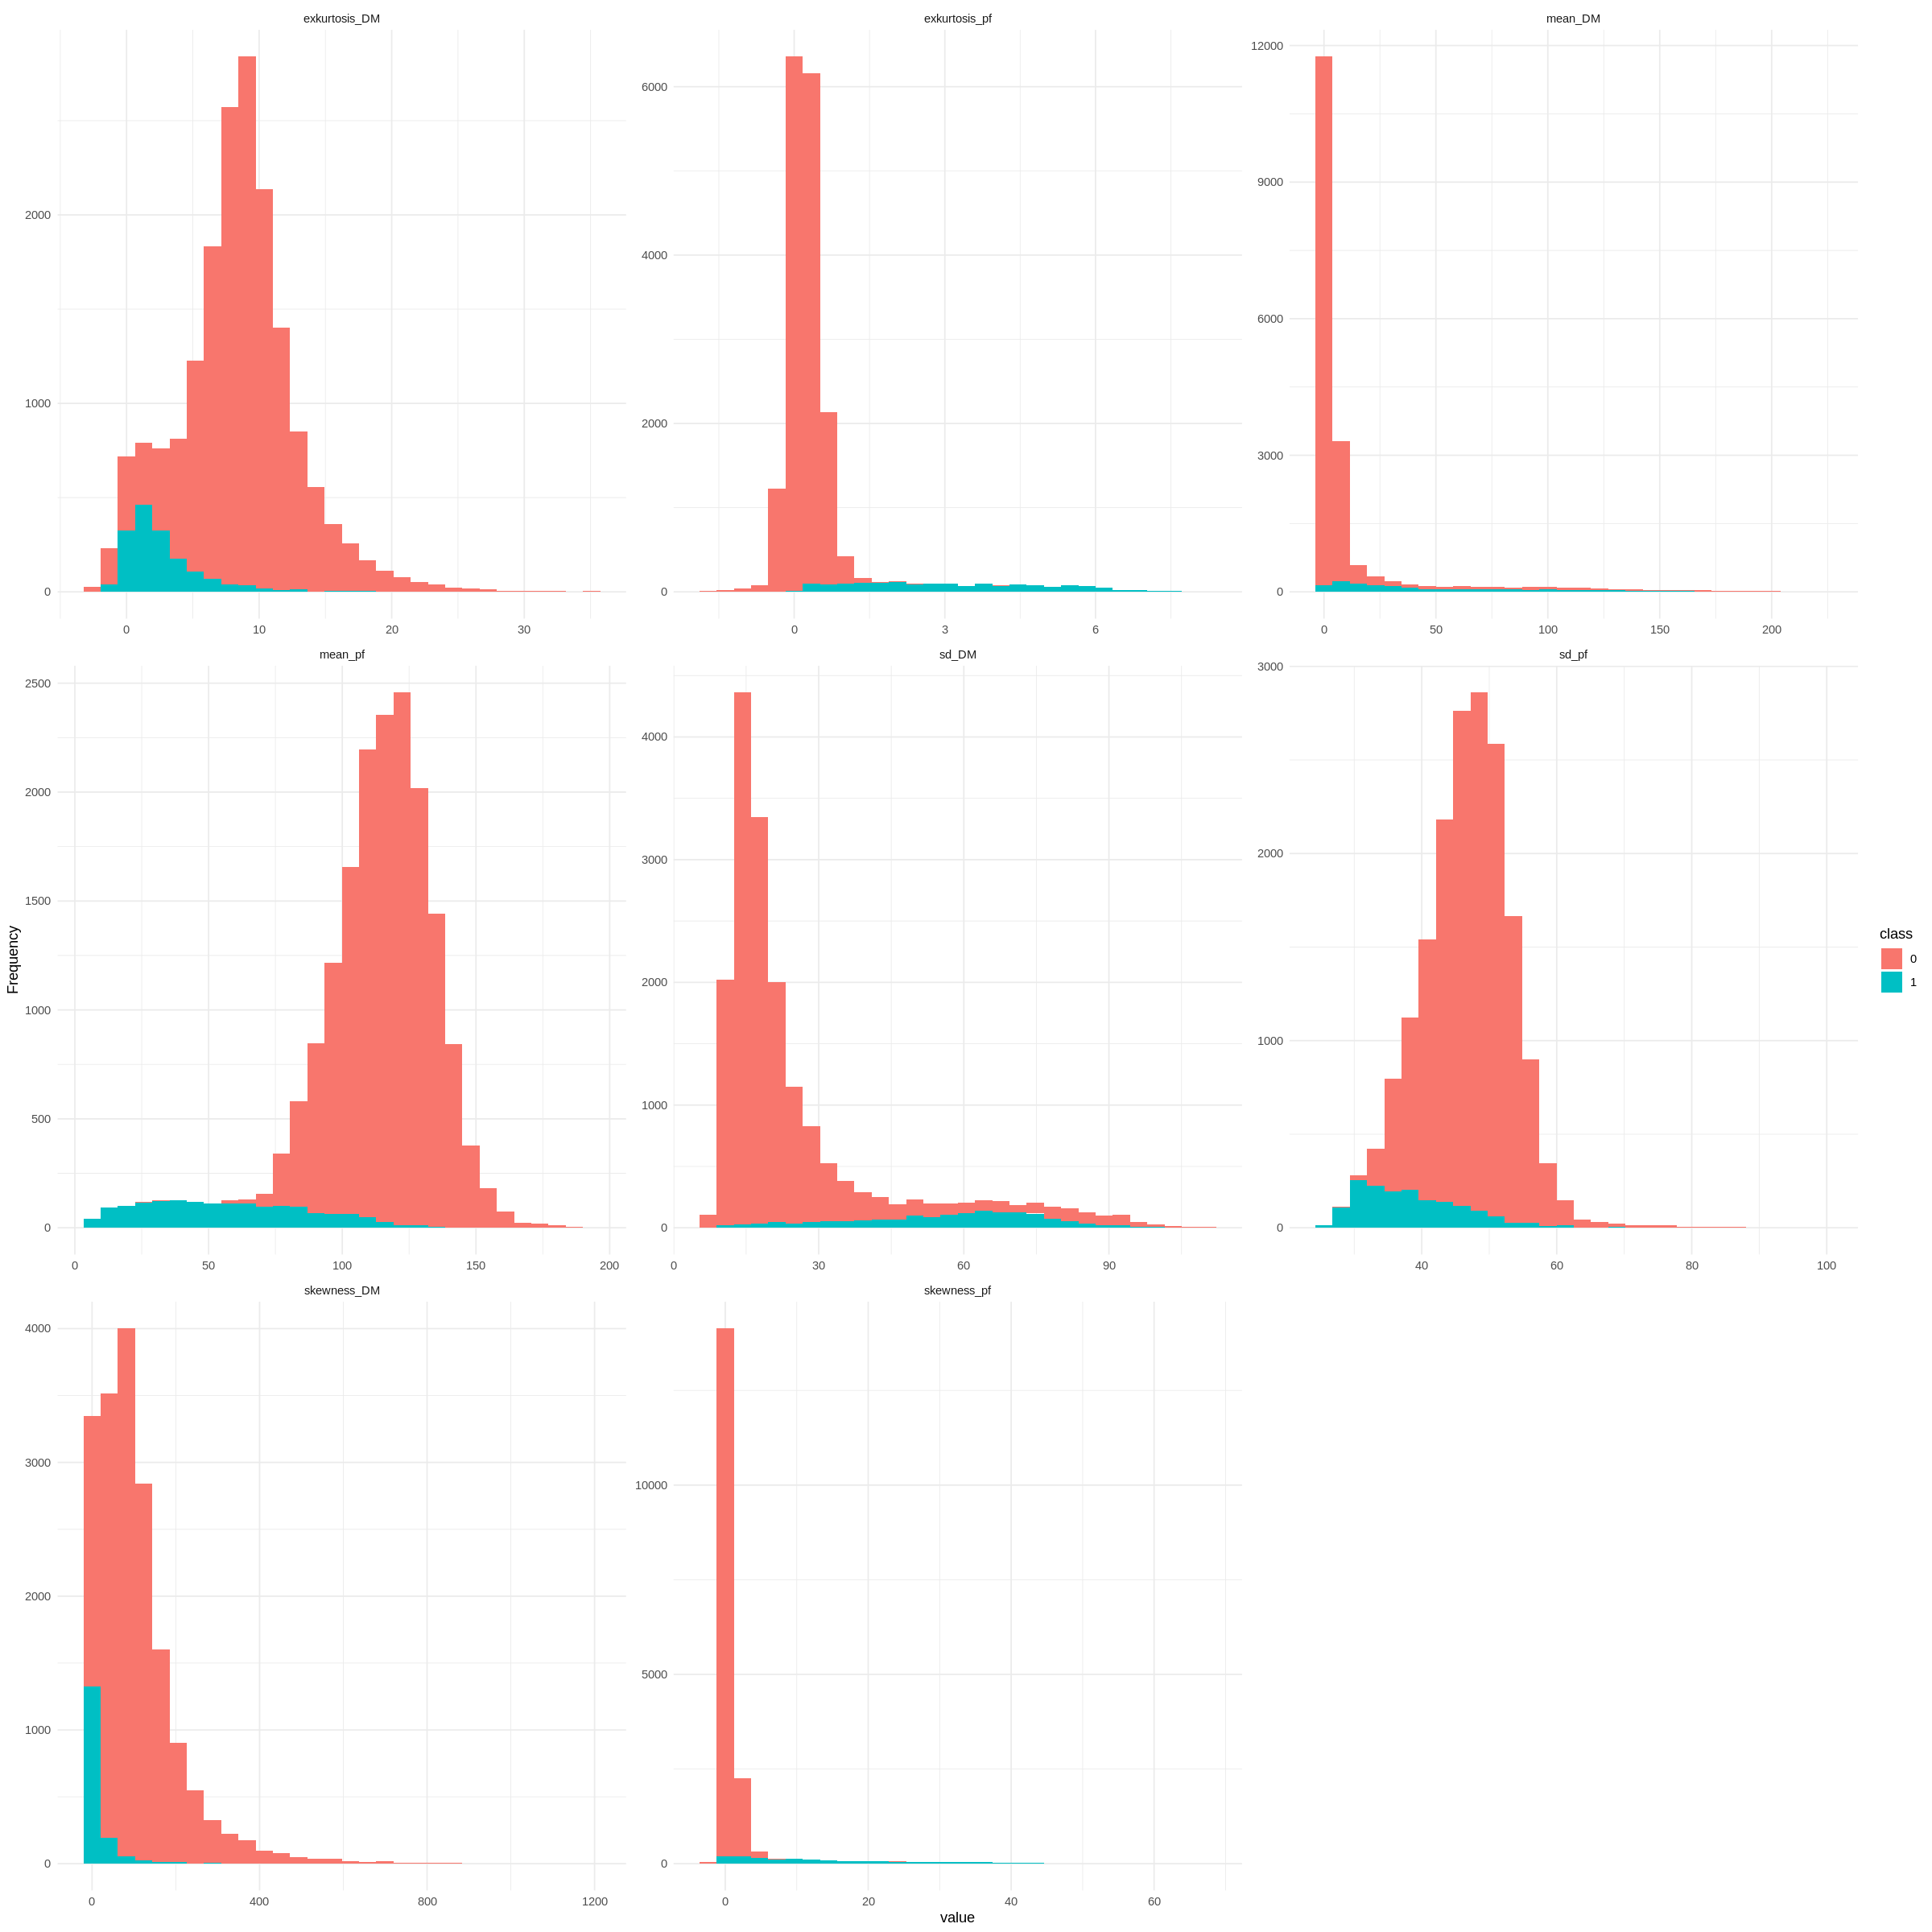

In [34]:
#visualization variables by class profile.
options(repr.plot.width = 20, repr.plot.height = 20)
HTRU_plot<-ggplot(HTRU_long,aes(x=value,fill=class))+
    geom_histogram()+
    facet_wrap(~ vars, scales = "free") +
    xlab("value")+
    ylab("Frequency")+
    theme_minimal()
HTRU_plot

In [10]:
HTRU_split <- initial_split(HTRU, prop = 0.75, strata = class)  
HTRU_train <- training(HTRU_split)   
HTRU_test <- testing(HTRU_split) #data spliting